In [2]:
# !pip install pulp pandas numpy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# Import your revenue helpers
# Make sure revenue_function.py is in the same folder as the notebook
from revenue_function import detect_time_window_for_aligned_blocks  # α_t + window detection
# (We will compute base_kwh per window logic here to feed into the optimizer.)

# --- Load your 15-min solar forecast CSV ---
# Expected columns at minimum:
#   ts_start, solar_forecast_mw, fit_rate, contract_kwh, egat_plan_kwh, has_egat_plan_in_win3
# If some are missing (e.g., egat_plan_kwh), we will handle per window logic.

csv_path = "data/day_ahead_15min_MW.csv"  # <-- change
df = pd.read_csv(csv_path)
df["ts_start"] = pd.to_datetime(df["timestamp"])
df["contract_kwh"] = 45*1000
df["egat_plan_kwh"] = 45*0.6*1000
df["has_egat_plan_in_win3"] = 0.6*45*1000
df['fit_rate'] = 4

# Ensure 15-min alignment
if not all(df["ts_start"].dt.minute.isin([0,15,30,45])):
    raise ValueError("ts_start must be aligned to :00/:15/:30/:45")

# Compute α_t (14/15 at 06:00, 16:00, 18:00) and select base per your rules
def compute_alpha_and_base(row):
    ts = row["ts_start"].to_pydatetime()
    window_id, adjusted = detect_time_window_for_aligned_blocks(ts)  # from your file
    alpha = (14.0/15.0) if adjusted else 1.0

    # Choose base_kwh by window, same as your compute_payment_for_interval()
    # Window 1 -> contract, Window 2 -> egat_plan, Window 3 -> depends on flag
    contract = row.get("contract_kwh", np.nan)
    egat_plan = row.get("egat_plan_kwh", np.nan)
    has_plan_w3 = row.get("has_egat_plan_in_win3", np.nan)

    if window_id == 1:
        base = float(contract)
    elif window_id == 2:
        base = float(egat_plan)
    else:  # window 3
        if pd.isna(has_plan_w3):
            raise ValueError("has_egat_plan_in_win3 is required for Window 3 rows")
        if bool(has_plan_w3):
            base = float(egat_plan)
        else:
            base = float(contract)
    return pd.Series({"alpha": alpha, "base_kwh": base, "window_id": window_id})

aux = df.apply(compute_alpha_and_base, axis=1)
df = pd.concat([df, aux], axis=1)

# Constants
DELTA_H = 0.25  # 15 minutes
MW_to_kWh = 1000.0 * DELTA_H

# --- Plant params: FILL THESE ---
params = {
    # Turbine U4 (min/max/ramp from your emulator; adjust as needed)
    "tur_Pmin": 7.0,    # MW
    "tur_Pmax": 36.0,   # MW
    "tur_ramp_MW_per_min": 6.0,  # MW/min (example from your code defaults)
    "tur_eta_dis": 1.0,           # if energy-limited turbine; else leave 1
    "tur_E_cap": 45.0,            # MWh (if energy-limited), else set huge
    "tur_E_init": 45.0,           # MWh
    "tur_start_cost": 0.0,        # currency per start (SET THIS)
    "tur_initial_on": 0,          # 1 or 0
    "tur_initial_P": 0.0,         # MW

    # BESS
    "bess_E_cap": 20.0,          # MWh (SET)
    "bess_SOC_init": 10.0,        # MWh (SET)
    "bess_P_dis_max": 10.0,       # MW (SET)
    "bess_P_ch_max": 10.0,        # MW (SET)
    "bess_eta_dis": 0.95,         # from your emulator defaults
    "bess_eta_ch": 0.95,          # from your emulator defaults
    "bess_ramp_MW_per_min": None, # optional ramp; set to number if needed
    "bess_cycle_cost": 0.0,       # currency per MWh throughput (optional)
    "bess_force_cycle_end": True, # True => SOC_end == SOC_init

    # Deviation >5% penalty
    "lambda_dev": 0.0,            # currency per kWh of exceedance (SET)
}
N = len(df)

C:\Users\Jarup\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Jarup\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


In [3]:
import pulp

model = pulp.LpProblem("RevenueMax_15min", pulp.LpMaximize)

# Index set
T = range(N)

# --- Decision variables ---
P_sol = pulp.LpVariable.dicts("P_sol", T, lowBound=0)               # MW
P_tur = pulp.LpVariable.dicts("P_tur", T, lowBound=0)               # MW
u     = pulp.LpVariable.dicts("u",     T, lowBound=0, upBound=1, cat="Binary")
y     = pulp.LpVariable.dicts("y",     T, lowBound=0, upBound=1, cat="Binary")

P_dis = pulp.LpVariable.dicts("P_dis", T, lowBound=0)               # MW
P_ch  = pulp.LpVariable.dicts("P_ch",  T, lowBound=0)               # MW
SOC   = pulp.LpVariable.dicts("SOC",   range(N+1), lowBound=0)      # MWh

E_kWh      = pulp.LpVariable.dicts("E_kWh", T, lowBound=0)          # net to grid (kWh)
E_adj_kWh  = pulp.LpVariable.dicts("E_adj_kWh", T, lowBound=0)      # alpha-adjusted
over_kWh   = pulp.LpVariable.dicts("over_kWh", T, lowBound=0)
short_kWh  = pulp.LpVariable.dicts("short_kWh", T, lowBound=0)

# deviation soft constraint
d_kWh      = pulp.LpVariable.dicts("d_kWh", T, lowBound=0)
excess_kWh = pulp.LpVariable.dicts("excess_kWh", T, lowBound=0)

# --- Parameters shortcuts ---
tur_Pmin = params["tur_Pmin"]
tur_Pmax = params["tur_Pmax"]
tur_ramp = params["tur_ramp_MW_per_min"]
tur_eta  = params["tur_eta_dis"]
tur_Ecap = params["tur_E_cap"]
tur_E0   = params["tur_E_init"]
tur_Csu  = params["tur_start_cost"]

bEcap  = params["bess_E_cap"]
bSOC0  = params["bess_SOC_init"]
bPdisM = params["bess_P_dis_max"]
bPchM  = params["bess_P_ch_max"]
bEd    = params["bess_eta_dis"]
bEc    = params["bess_eta_ch"]
bRamp  = params["bess_ramp_MW_per_min"]
bCyc   = params["bess_cycle_cost"]
lambda_dev = params["lambda_dev"]

# --- Initial conditions ---
model += SOC[0] == bSOC0
# If energy-limited turbine storage is modeled, we represent it as part of constraints below via a separate E_tur state.
# For simplicity, we approximate with a scalar state:
E_tur = pulp.LpVariable.dicts("E_tur", range(N+1), lowBound=0, upBound=tur_Ecap)
model += E_tur[0] == tur_E0
P_tur_prev = params["tur_initial_P"]
u_prev = params["tur_initial_on"]

# --- Constraints per period ---
for t in T:
    # Solar caps
    model += P_sol[t] <= float(df.loc[t, "solar_forecast_mw"])

    # Turbine on/off & min/max
    model += P_tur[t] <= u[t] * tur_Pmax
    model += P_tur[t] >= u[t] * tur_Pmin

    # Turbine start-up logic
    if t == 0:
        model += y[t] >= u[t] - u_prev
    else:
        model += y[t] >= u[t] - u[t-1]

    # Turbine ramp
    if tur_ramp is not None:
        ramp_MW = tur_ramp * 15.0  # MW per 15 min
        if t == 0:
            model += P_tur[t] - P_tur_prev <= ramp_MW
            model += P_tur_prev - P_tur[t] <= ramp_MW
        else:
            model += P_tur[t] - P_tur[t-1] <= ramp_MW
            model += P_tur[t-1] - P_tur[t] <= ramp_MW

    # Turbine energy store (if you want to enforce energy feasibility)
    model += E_tur[t+1] == E_tur[t] - (P_tur[t]/max(tur_eta,1e-6))*DELTA_H  # discharge-only
    # Bounds included via variable upperBound=tur_Ecap; lowerBound=0

    # BESS power caps
    model += P_dis[t] <= bPdisM
    model += P_ch[t]  <= bPchM

    # Optional BESS ramp on net power (simple)
    if bRamp is not None:
        ramp_MW = bRamp * 15.0
        if t == 0:
            # assume previous net power 0 MW
            model += (P_dis[t] - P_ch[t]) <= ramp_MW
            model += -(P_dis[t] - P_ch[t]) <= ramp_MW
        else:
            model += (P_dis[t] - P_ch[t]) - (P_dis[t-1] - P_ch[t-1]) <= ramp_MW
            model += -((P_dis[t] - P_ch[t]) - (P_dis[t-1] - P_ch[t-1])) <= ramp_MW

    # BESS SOC dynamics
    model += SOC[t+1] == SOC[t] - (P_dis[t]/max(bEd,1e-6))*DELTA_H + (P_ch[t]*bEc)*DELTA_H
    model += SOC[t+1] <= bEcap

    # Net energy to grid (kWh)
    model += E_kWh[t] == MW_to_kWh*(P_sol[t] + P_tur[t] + P_dis[t] - P_ch[t])

    # Adjusted energy (alpha factor from your FiT rules)
    alpha = float(df.loc[t, "alpha"])
    base  = float(df.loc[t, "base_kwh"])
    FiT   = float(df.loc[t, "fit_rate"])

    model += E_adj_kWh[t] == alpha * E_kWh[t]

    # Piecewise linear payment parts
    model += over_kWh[t]  >= E_adj_kWh[t] - base
    model += over_kWh[t]  >= 0
    model += short_kWh[t] >= base - E_adj_kWh[t]
    model += short_kWh[t] >= 0

    # Deviation soft band ±5% of base
    model += d_kWh[t] >= E_adj_kWh[t] - base
    model += d_kWh[t] >= base - E_adj_kWh[t]
    model += excess_kWh[t] >= d_kWh[t] - 0.05*base
    model += excess_kWh[t] >= 0

# Close the day with same SOC (optional but common for planning)
if params["bess_force_cycle_end"]:
    model += SOC[N] == bSOC0

# --- Objective ---
payment_terms = []
penalty_terms = []
for t in T:
    FiT = float(df.loc[t, "fit_rate"])
    payment_terms.append( FiT * (E_adj_kWh[t] - over_kWh[t]) )     # cap above base
    penalty_terms.append( 0.12 * FiT * short_kWh[t] )              # shortfall penalty per FiT rules

obj = (
    pulp.lpSum(payment_terms) 
    - pulp.lpSum(penalty_terms)
    - tur_Csu * pulp.lpSum([y[t] for t in T])
    - lambda_dev * pulp.lpSum([excess_kWh[t] for t in T])
    - bCyc * pulp.lpSum([DELTA_H * (P_dis[t] + P_ch[t]) for t in T])
)

model += obj

In [4]:
# Solve
model.solve(pulp.PULP_CBC_CMD(msg=True))  # or your installed solver

print("Status:", pulp.LpStatus[model.status])
print("Objective value (currency):", pulp.value(model.objective))

# Collect results
out = df.copy()
out["p_sol_mw"]   = [pulp.value(P_sol[t]) for t in T]
out["p_tur_mw"]   = [pulp.value(P_tur[t]) for t in T]
out["p_dis_mw"]   = [pulp.value(P_dis[t]) for t in T]
out["p_ch_mw"]    = [pulp.value(P_ch[t])  for t in T]
out["u_tur"]      = [int(round(pulp.value(u[t]))) for t in T]
out["y_start"]    = [int(round(pulp.value(y[t]))) for t in T]
out["E_kWh"]      = [pulp.value(E_kWh[t]) for t in T]
out["E_adj_kWh"]  = [pulp.value(E_adj_kWh[t]) for t in T]
out["over_kWh"]   = [pulp.value(over_kWh[t]) for t in T]
out["short_kWh"]  = [pulp.value(short_kWh[t]) for t in T]
out["dev_kWh"]    = [pulp.value(d_kWh[t]) for t in T]
out["dev_excess"] = [pulp.value(excess_kWh[t]) for t in T]
out["soc_mwh"]    = [pulp.value(SOC[t]) for t in T]
# out["soc_mwh"]    = [pulp.value(SOC[t]) for t in T] + [pulp.value(SOC[N])]
out.to_csv("optimized_schedule_15min.csv", index=False)
out.head()

Status: Optimal
Objective value (currency): 1974043.6963999984


,timestamp,solar_forecast_mw,ts_start,contract_kwh,egat_plan_kwh,has_egat_plan_in_win3,fit_rate,alpha,base_kwh,window_id,...,p_ch_mw,u_tur,y_start,E_kWh,E_adj_kWh,over_kWh,short_kWh,dev_kWh,dev_excess,soc_mwh
0,2026-01-03T00:00:00,0.0,2026-01-03 00:00:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0,1,0.0,0.0,0.0,27000.0,27000.0,25650.0,10.0
1,2026-01-03T00:15:00,0.0,2026-01-03 00:15:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0,1,0.0,0.0,0.0,27000.0,27000.0,25650.0,10.0
2,2026-01-03T00:30:00,0.0,2026-01-03 00:30:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0,1,0.0,0.0,0.0,27000.0,27000.0,25650.0,10.0
3,2026-01-03T00:45:00,0.0,2026-01-03 00:45:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0,1,0.0,0.0,0.0,27000.0,27000.0,25650.0,10.0
4,2026-01-03T01:00:00,0.0,2026-01-03 01:00:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0,1,0.0,0.0,0.0,27000.0,27000.0,25650.0,10.0


In [5]:
# We need to pass E_read_kwh (= actual metered energy). Your function applies alpha internally.
check_df = out[["ts_start","E_kWh","fit_rate","base_kwh","window_id"]].copy()
# For batch call, we need: ts_start, e_read_kwh, fit_rate, and the base drivers:
check_df = check_df.rename(columns={"E_kWh":"e_read_kwh"})

# Add the driver columns expected by revenue_function.compute_revenue_rows:
# We'll reuse original df's contract/egat_plan/has_plan columns:
for c in ["contract_kwh","egat_plan_kwh","has_egat_plan_in_win3"]:
    if c in df.columns:
        check_df[c] = df[c]

from revenue_function import compute_revenue_rows
revenue_rows = compute_revenue_rows(check_df)  # computes window, alpha, cap & penalties
total_payment = revenue_rows["payment_currency"].sum()
print("Payment recomputed with your function:", total_payment)

Payment recomputed with your function: 1974043.6765333335


In [6]:
check_df

,ts_start,e_read_kwh,fit_rate,base_kwh,window_id,contract_kwh,egat_plan_kwh,has_egat_plan_in_win3
0,2026-01-03 00:00:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
1,2026-01-03 00:15:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
2,2026-01-03 00:30:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
3,2026-01-03 00:45:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
4,2026-01-03 01:00:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
...,...,...,...,...,...,...,...,...
91,2026-01-03 22:45:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
92,2026-01-03 23:00:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
93,2026-01-03 23:15:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0
94,2026-01-03 23:30:00,0.0,10,27000.0,2.0,45000,27000.0,27000.0


Visualization

In [8]:
# If needed:
# !pip install pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# High-DPI plots
%config InlineBackend.figure_format = 'retina'

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

In [9]:
# Change path if needed
RESULT_CSV = "optimized_schedule_15min.csv"

df = pd.read_csv(RESULT_CSV, parse_dates=["ts_start"])

# Sort just in case and ensure 15-min frequency
df = df.sort_values("ts_start").reset_index(drop=True)
assert df["ts_start"].dt.minute.isin([0,15,30,45]).all(), "ts_start must be aligned to 15-min grid."

# Convenience columns
df["p_bess_net_mw"] = df["p_dis_mw"] - df["p_ch_mw"]    # + = discharge, - = charge
df["p_total_mw"]    = df["p_sol_mw"] + df["p_tur_mw"] + df["p_bess_net_mw"]

# If your day spans multiple dates, we’ll facet by date for energy plots
df["date"] = df["ts_start"].dt.date

In [10]:
from revenue_function import compute_revenue_rows  # your file
# Prepare the input columns the function expects:
revenue_in = df[["ts_start","E_kWh","fit_rate"]].rename(columns={"E_kWh":"e_read_kwh"}).copy()

# If you had these drivers in the optimization input, attach them back here:
for col in ["contract_kwh","egat_plan_kwh","has_egat_plan_in_win3"]:
    if col in df.columns:
        revenue_in[col] = df[col]

rev_rows = compute_revenue_rows(revenue_in)
df["payment_currency"] = rev_rows["payment_currency"].values  # aligned row-wise
print("Total payment (verified with your function):", df["payment_currency"].sum())

Total payment (verified with your function): 1974043.6765333335


In [11]:
df

,timestamp,solar_forecast_mw,ts_start,contract_kwh,egat_plan_kwh,has_egat_plan_in_win3,fit_rate,alpha,base_kwh,window_id,...,E_adj_kWh,over_kWh,short_kWh,dev_kWh,dev_excess,soc_mwh,p_bess_net_mw,p_total_mw,date,payment_currency
0,2026-01-03T00:00:00,0.0,2026-01-03 00:00:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
1,2026-01-03T00:15:00,0.0,2026-01-03 00:15:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
2,2026-01-03T00:30:00,0.0,2026-01-03 00:30:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
3,2026-01-03T00:45:00,0.0,2026-01-03 00:45:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
4,2026-01-03T01:00:00,0.0,2026-01-03 01:00:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2026-01-03T22:45:00,0.0,2026-01-03 22:45:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
92,2026-01-03T23:00:00,0.0,2026-01-03 23:00:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
93,2026-01-03T23:15:00,0.0,2026-01-03 23:15:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0
94,2026-01-03T23:30:00,0.0,2026-01-03 23:30:00,45000,27000.0,27000.0,10,1.0,27000.0,2.0,...,0.0,0.0,27000.0,27000.0,25650.0,10.0,0.0,0.0,2026-01-03,-32400.0


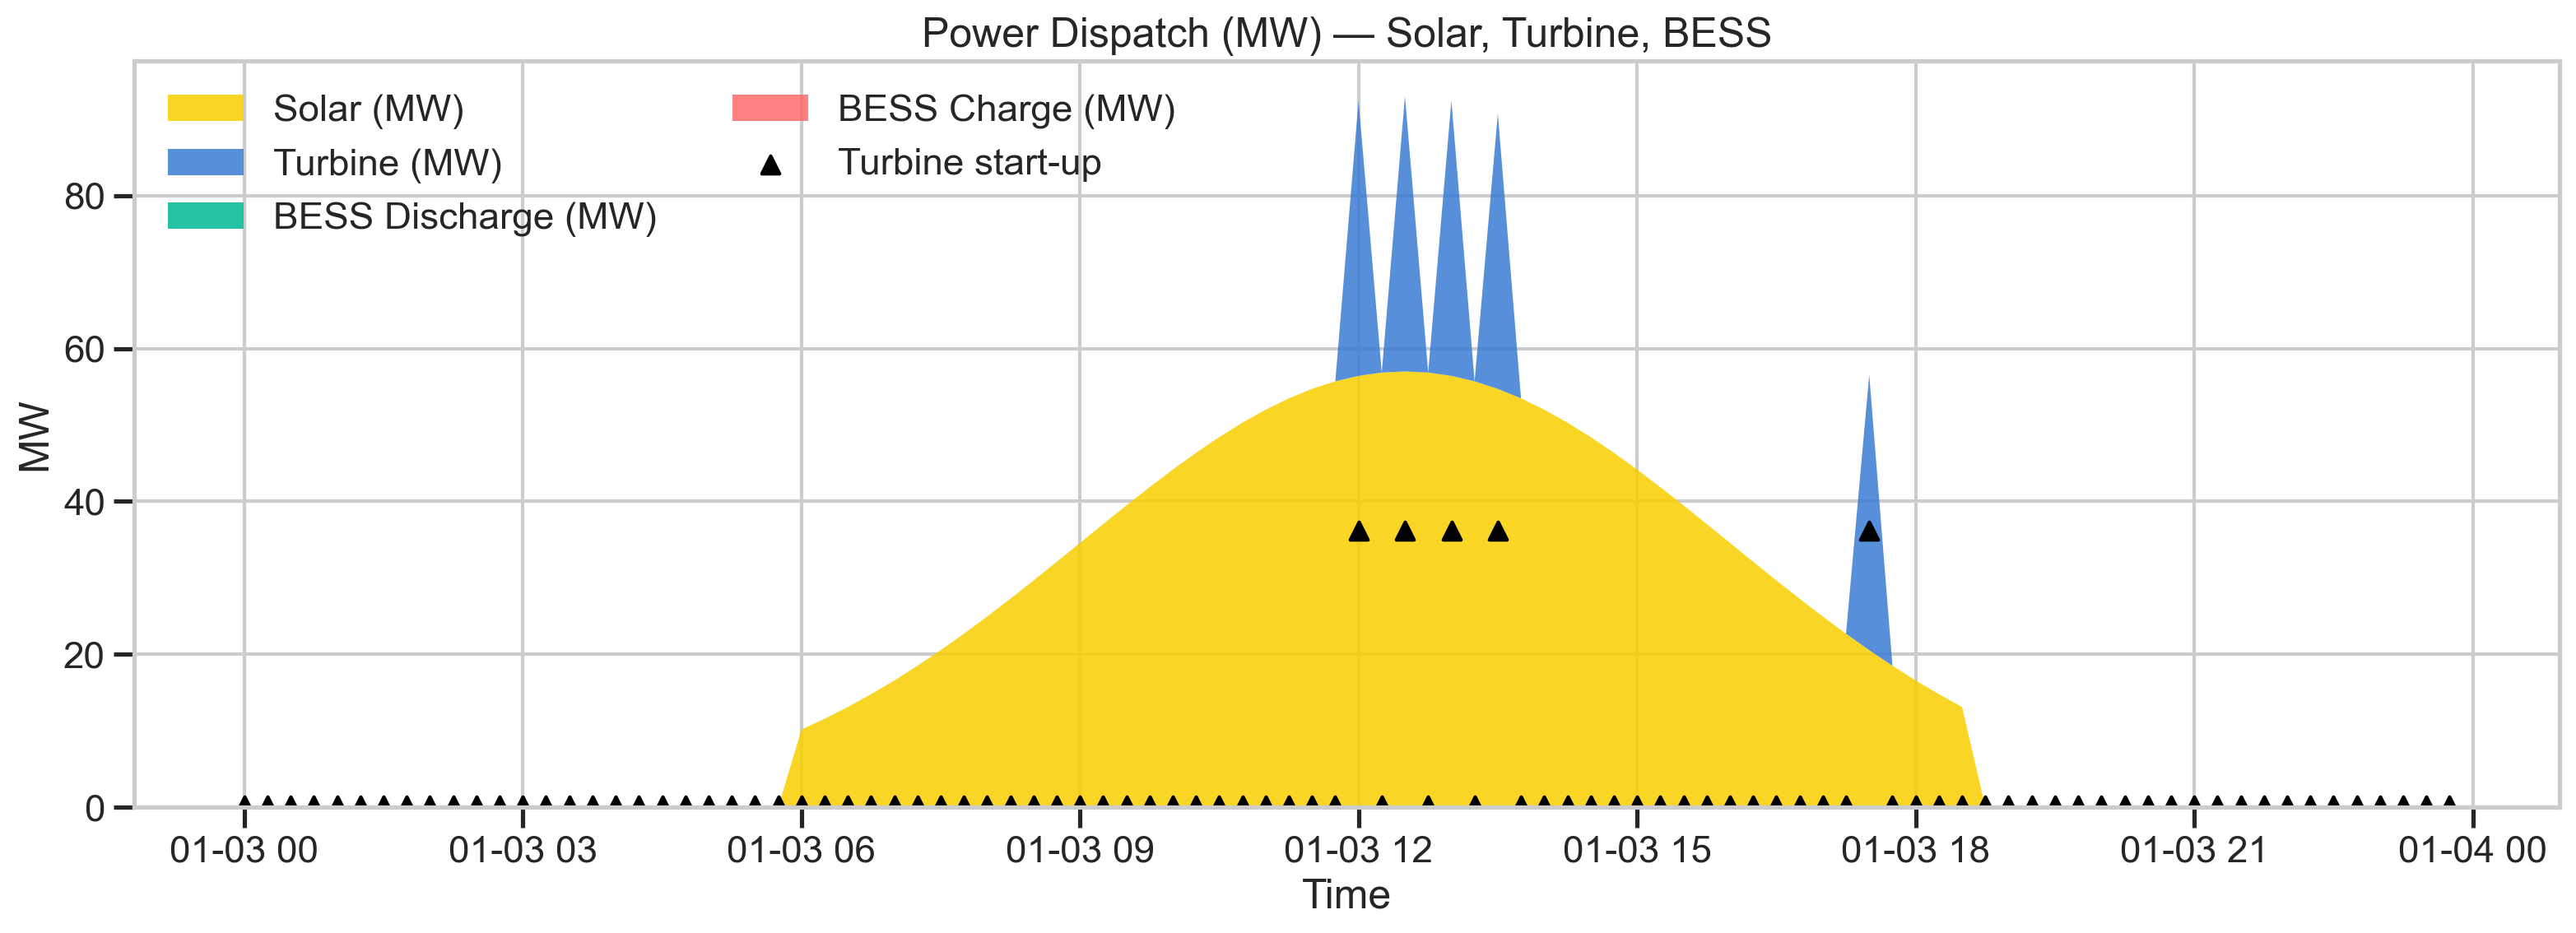

In [12]:
fig, ax = plt.subplots(figsize=(16, 6))

# For stacked area: split BESS into + and - for nicer display
p_bess_pos = df["p_bess_net_mw"].clip(lower=0)
p_bess_neg = df["p_bess_net_mw"].clip(upper=0)

ax.stackplot(
    df["ts_start"],
    df["p_sol_mw"], df["p_tur_mw"], p_bess_pos, -p_bess_neg,  # -neg => positive area for charge
    labels=["Solar (MW)", "Turbine (MW)", "BESS Discharge (MW)", "BESS Charge (MW)"],
    colors=["#f9cf00", "#3a7bd5", "#00b894", "#fd6b6b"],
    alpha=0.85
)

# Turbine start-ups as markers on top of turbine trace
start_idx = df.index[df.get("y_start", 0) == 1].tolist()
if len(start_idx):
    ax.scatter(df.loc[start_idx, "ts_start"], df.loc[start_idx, "p_tur_mw"] + 0.2,
               marker="^", color="black", s=60, label="Turbine start-up")

ax.set_title("Power Dispatch (MW) — Solar, Turbine, BESS")
ax.set_xlabel("Time")
ax.set_ylabel("MW")
ax.legend(loc="upper left", ncols=2)
plt.tight_layout()
plt.show()

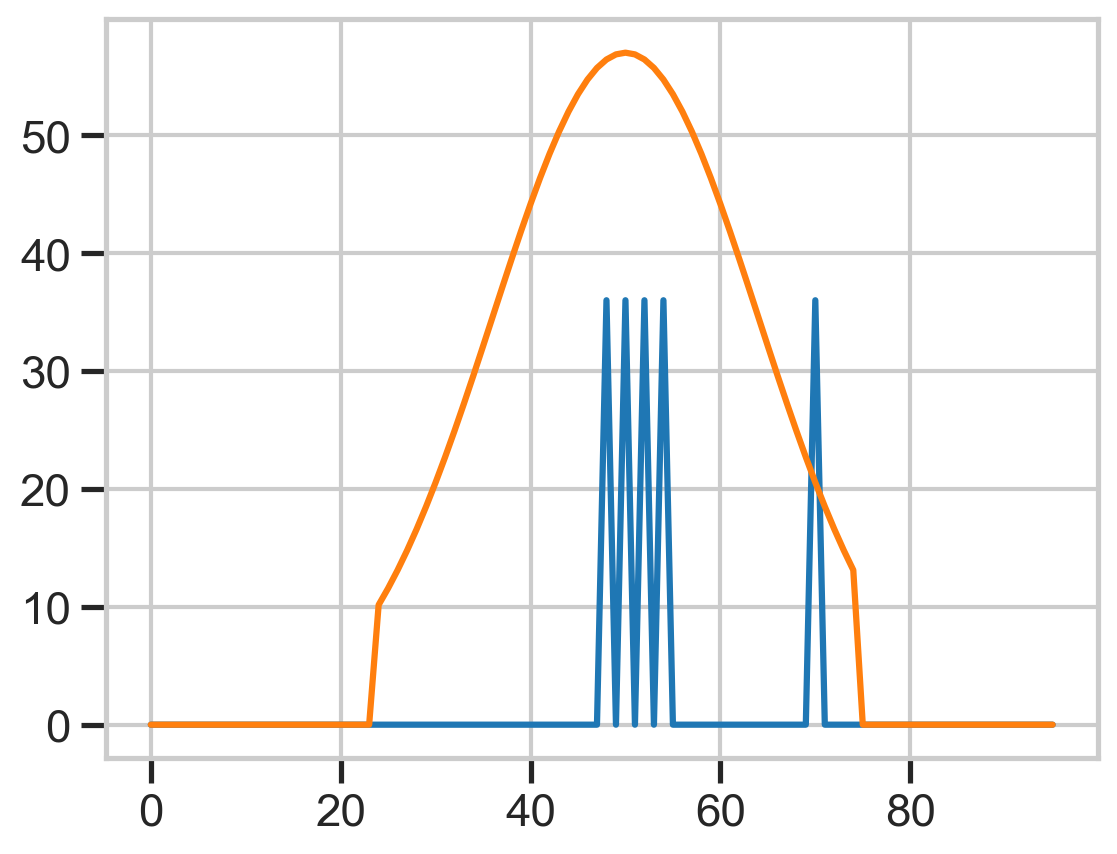

In [13]:
plt.plot(df["p_tur_mw"])
plt.plot(df["solar_forecast_mw"])

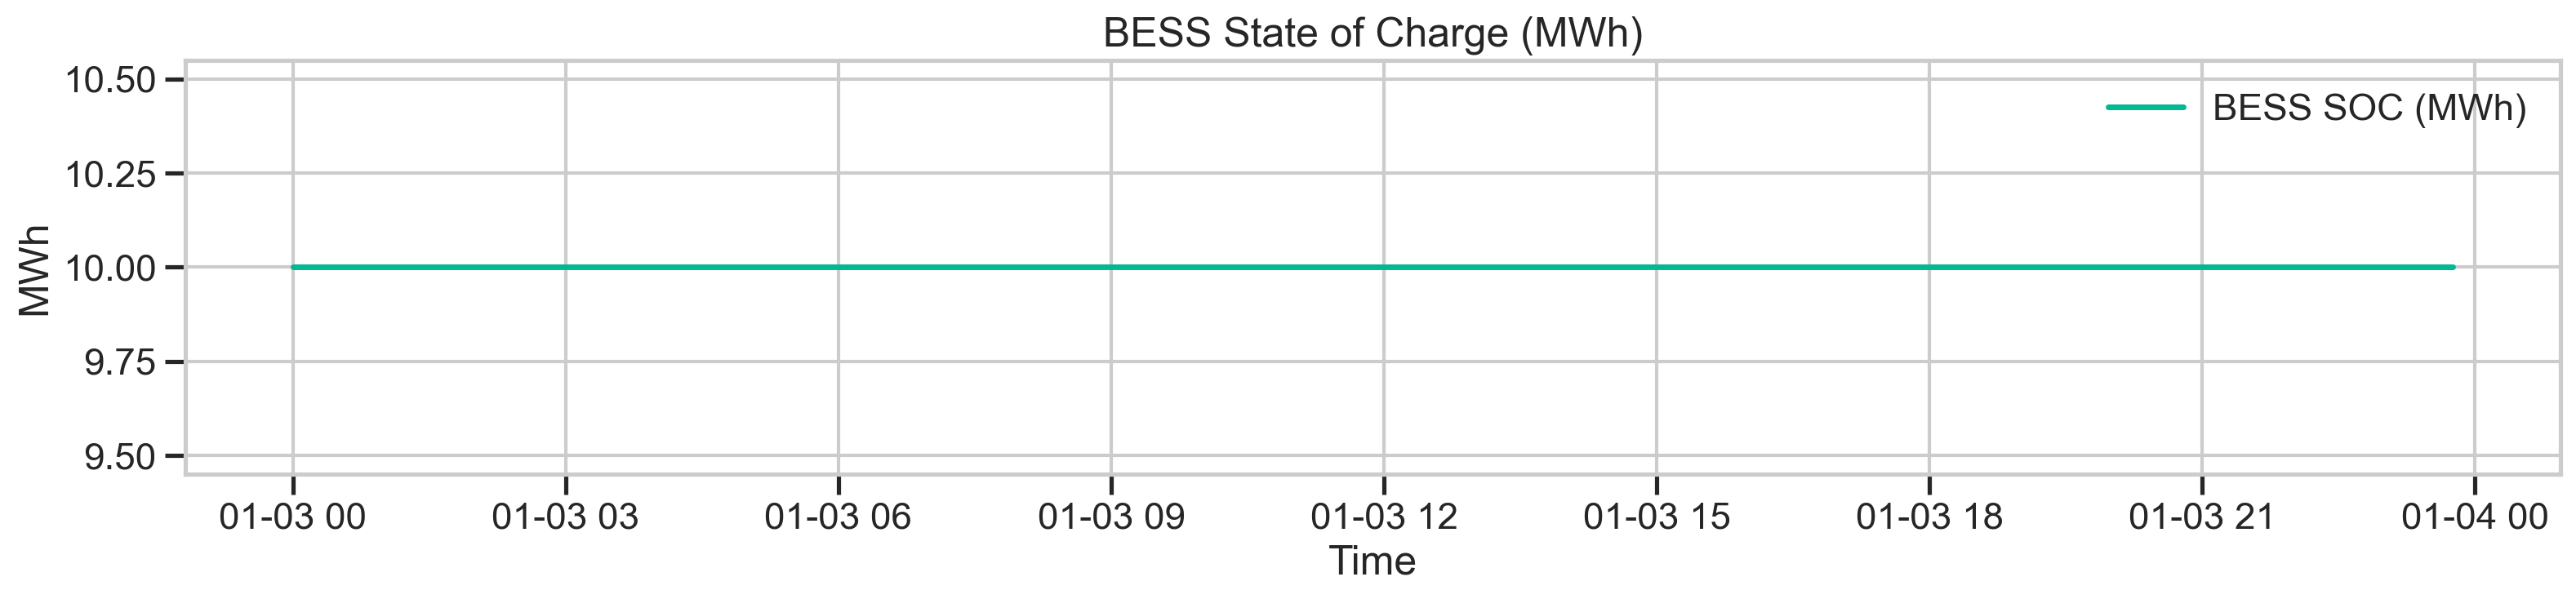

In [14]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df["ts_start"], df["soc_mwh"], color="#00b894", linewidth=2.5, label="BESS SOC (MWh)")
ax.set_title("BESS State of Charge (MWh)")
ax.set_xlabel("Time")
ax.set_ylabel("MWh")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

In [15]:
if "E_tur" in df.columns:
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(df["ts_start"], df["E_tur"], color="#3a7bd5", linewidth=2.5, label="Turbine Energy Store (MWh)")
    ax.set_title("Turbine Reservoir / Energy Store (MWh)")
    ax.set_xlabel("Time"); ax.set_ylabel("MWh"); ax.legend(); plt.tight_layout(); plt.show()

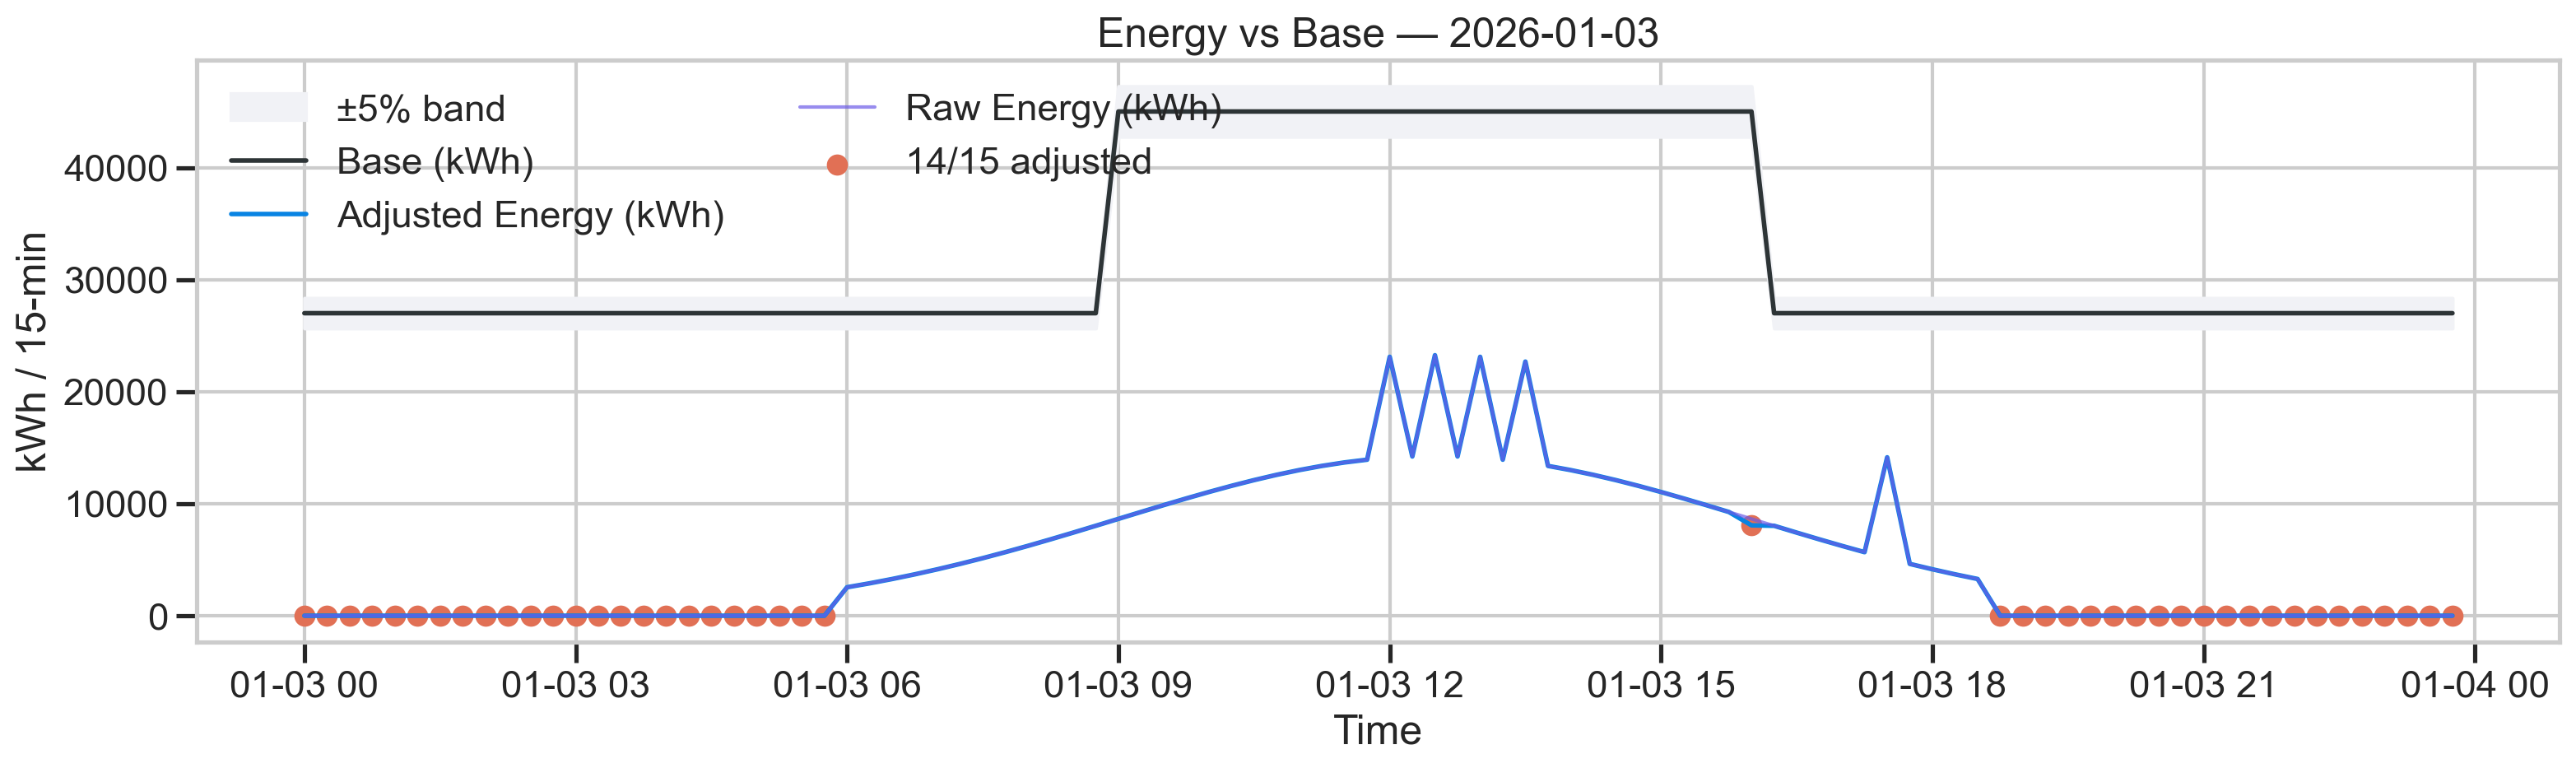

In [16]:
# Build +/-5% band
df["base_plus_5"]  = df["base_kwh"] * 1.05
df["base_minus_5"] = df["base_kwh"] * 0.95

# 14/15 adjusted markers = places where E_adj != E_kWh
adj_mask = np.isclose(df["E_adj_kWh"], df["E_kWh"] * (14.0/15.0), rtol=1e-6)

# If multi-day, facet by date:
for d, dfd in df.groupby("date"):
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.fill_between(dfd["ts_start"], dfd["base_minus_5"], dfd["base_plus_5"], color="#f1f2f6", label="±5% band")
    ax.plot(dfd["ts_start"], dfd["base_kwh"], color="#2d3436", lw=2, label="Base (kWh)")
    ax.plot(dfd["ts_start"], dfd["E_adj_kWh"], color="#0984e3", lw=2, label="Adjusted Energy (kWh)")
    ax.plot(dfd["ts_start"], dfd["E_kWh"], color="#6c5ce7", lw=1.5, alpha=0.7, label="Raw Energy (kWh)")

    # Mark adjusted points
    idx = dfd.index.intersection(df.index[adj_mask])
    ax.scatter(df.loc[idx, "ts_start"], df.loc[idx, "E_adj_kWh"], s=60, color="#e17055", marker="o", label="14/15 adjusted")

    ax.set_title(f"Energy vs Base — {d}")
    ax.set_xlabel("Time"); ax.set_ylabel("kWh / 15-min")
    ax.legend(loc="upper left", ncols=2)
    plt.tight_layout(); plt.show()

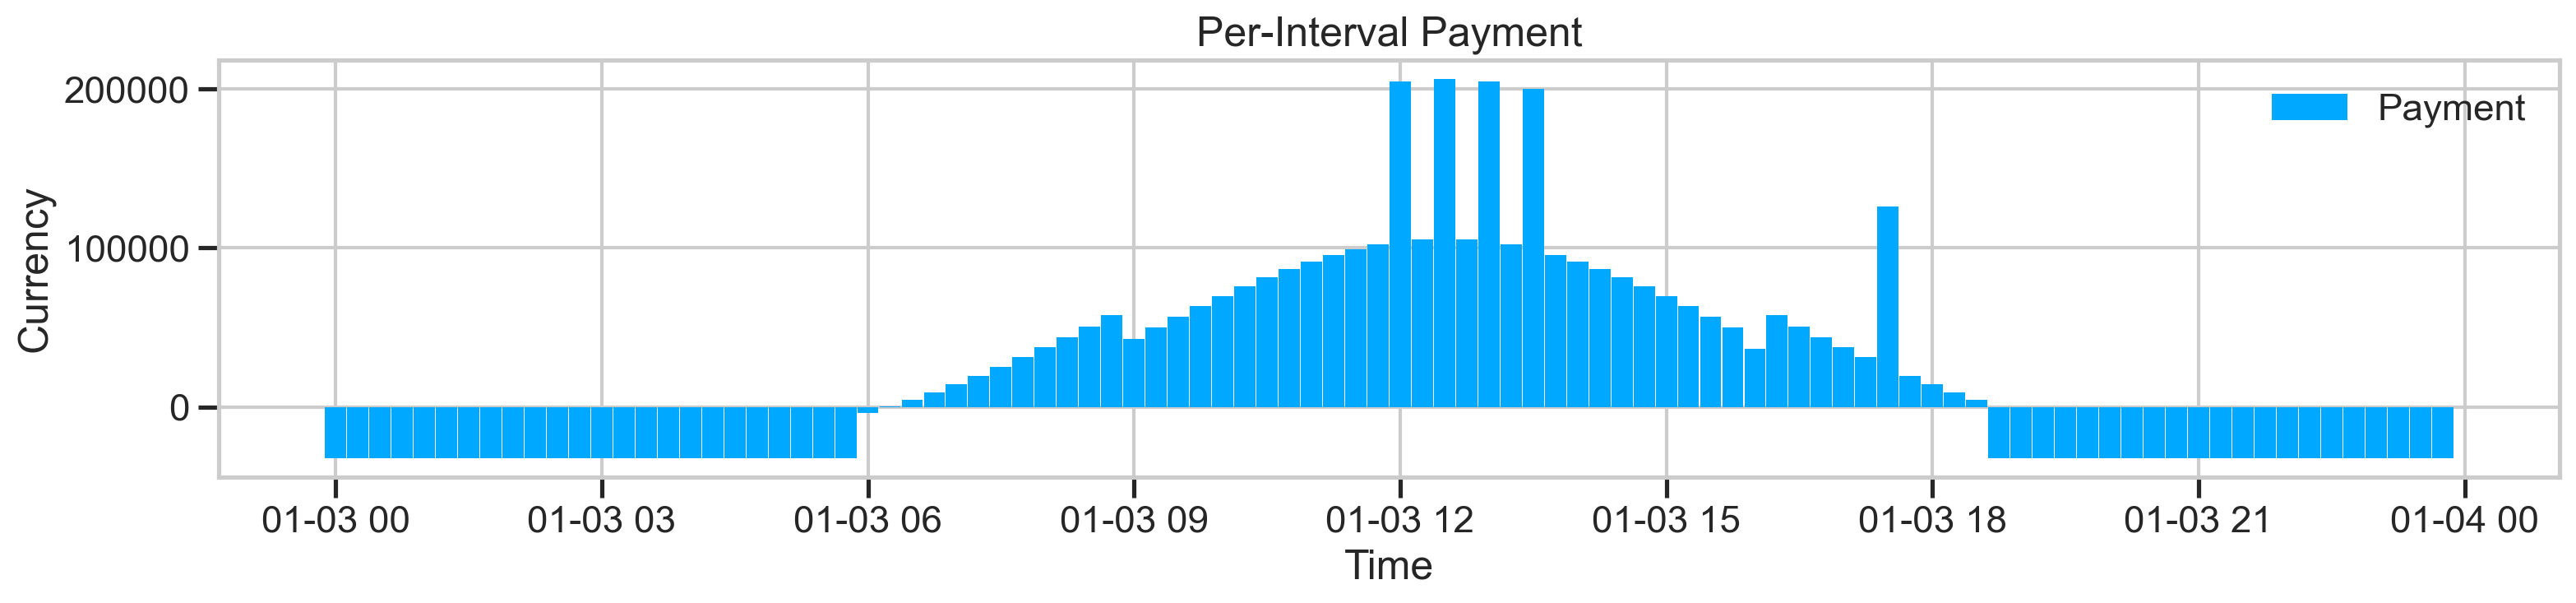

Total payment: 1974043.6765333335


In [17]:
if "payment_currency" in df.columns:
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.bar(df["ts_start"], df["payment_currency"], width=0.010, color="#00a8ff", label="Payment")
    ax.set_title("Per-Interval Payment")
    ax.set_xlabel("Time"); ax.set_ylabel("Currency")
    ax.legend(); plt.tight_layout(); plt.show()

    print("Total payment:", df["payment_currency"].sum())

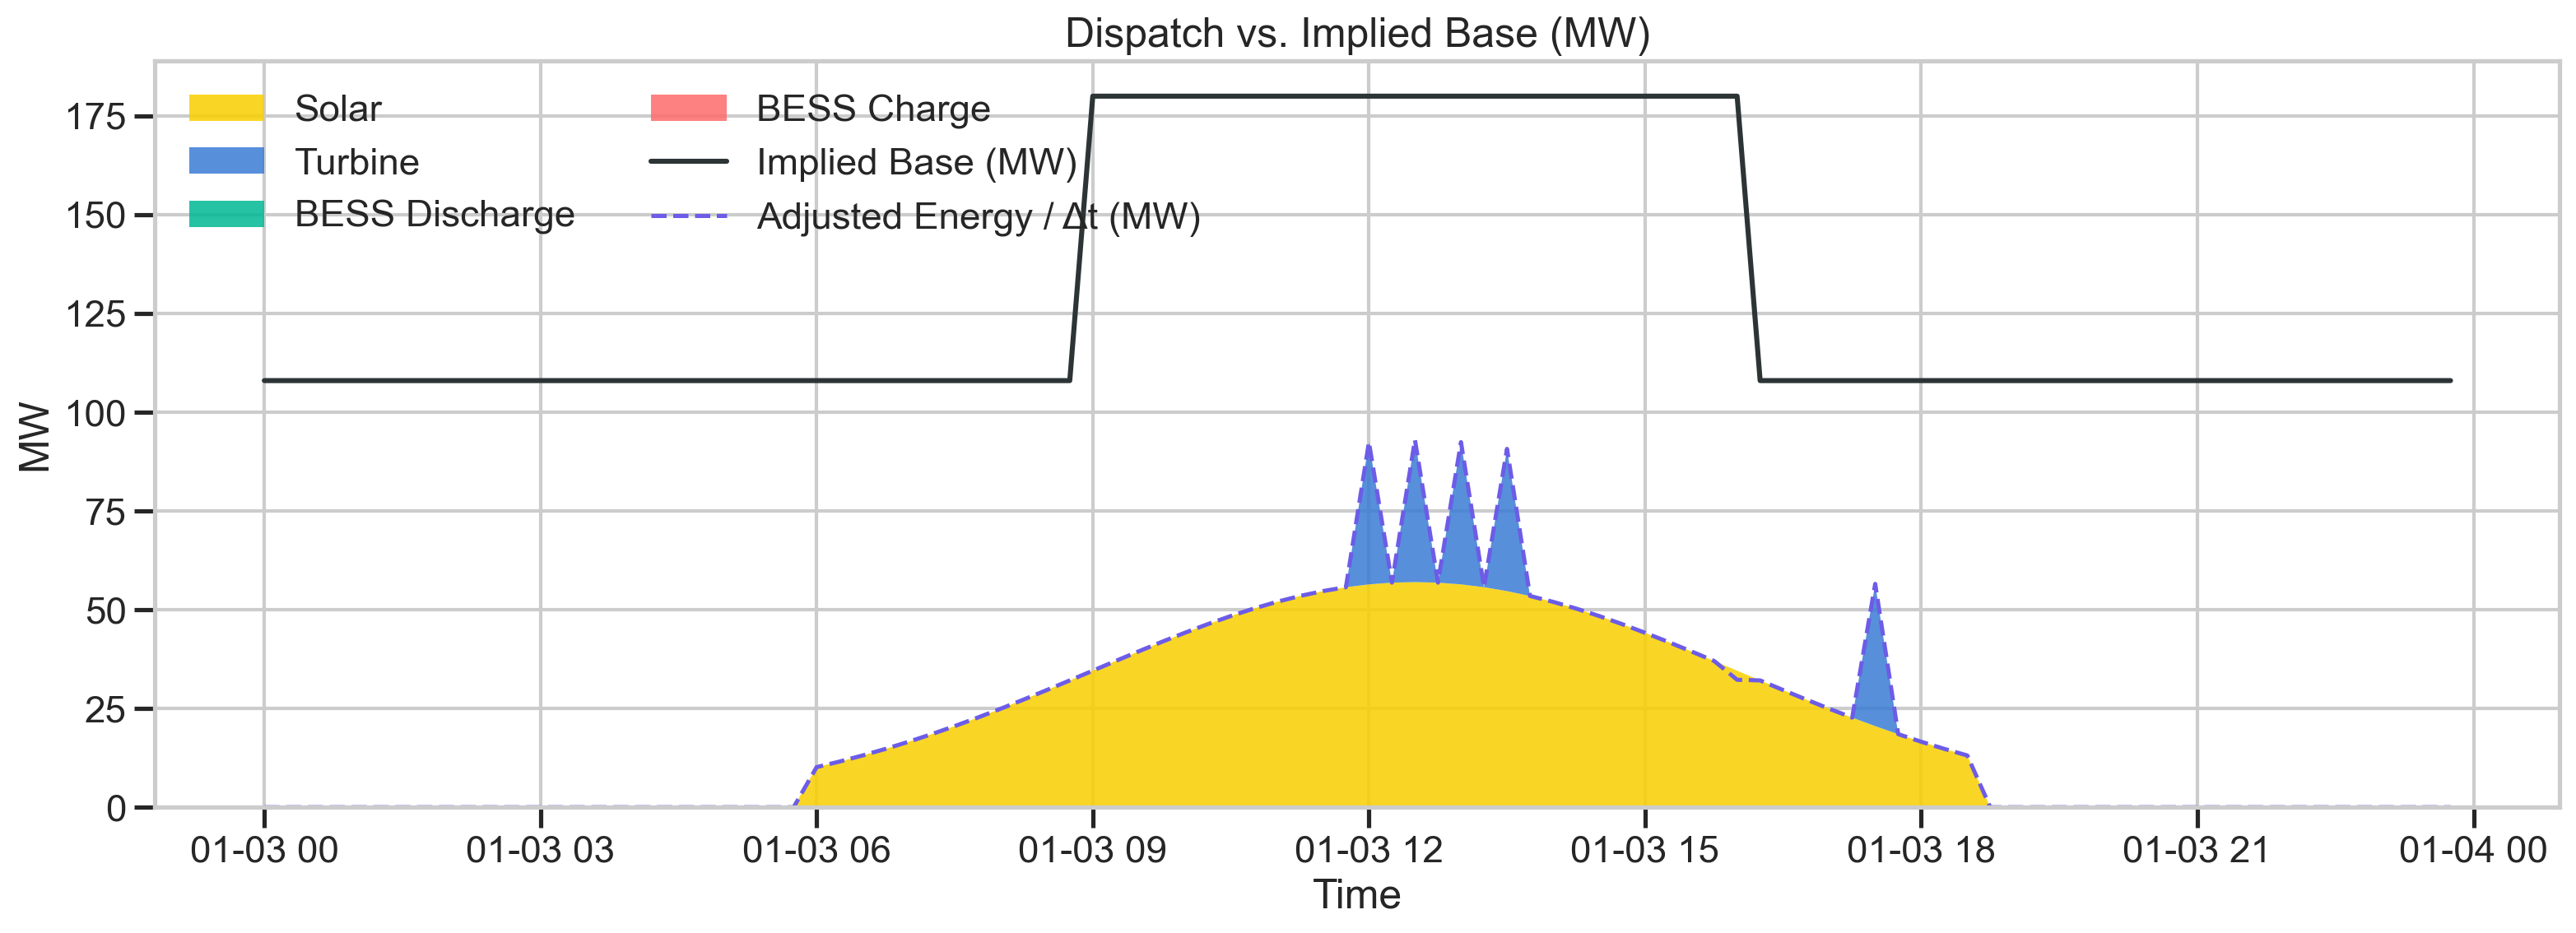

In [18]:
DELTA_H = 0.25
base_MW = df["base_kwh"] / (1000.0 * DELTA_H)
e_adj_MW = df["E_adj_kWh"] / (1000.0 * DELTA_H)

fig, ax = plt.subplots(figsize=(16, 6))
ax.stackplot(
    df["ts_start"],
    df["p_sol_mw"], df["p_tur_mw"], df["p_bess_net_mw"].clip(lower=0), -df["p_bess_net_mw"].clip(upper=0),
    labels=["Solar", "Turbine", "BESS Discharge", "BESS Charge"],
    colors=["#f9cf00", "#3a7bd5", "#00b894", "#fd6b6b"],
    alpha=0.85
)
ax.plot(df["ts_start"], base_MW, color="#2d3436", lw=2.2, label="Implied Base (MW)")
ax.plot(df["ts_start"], e_adj_MW, color="#6c5ce7", lw=1.8, linestyle="--", label="Adjusted Energy / Δt (MW)")

ax.set_title("Dispatch vs. Implied Base (MW)")
ax.set_xlabel("Time"); ax.set_ylabel("MW")
ax.legend(loc="upper left", ncols=2)
plt.tight_layout(); plt.show()

In [19]:
kpis = {
    "Total energy to grid (MWh)": df["E_kWh"].sum()/1000.0,
    "Total adjusted energy (MWh)": df["E_adj_kWh"].sum()/1000.0,
    "Total over-cap (kWh)": df["over_kWh"].sum(),
    "Total shortfall (kWh)": df["short_kWh"].sum(),
    "Intervals with >5% deviation": int((df["dev_excess"] > 0).sum()),
}
if "payment_currency" in df.columns:
    kpis["Total payment (currency)"] = df["payment_currency"].sum()

pd.Series(kpis)

Total energy to grid (MWh)      5.104730e+02
Total adjusted energy (MWh)     5.098968e+02
Total over-cap (kWh)            0.000000e+00
Total shortfall (kWh)           2.604103e+06
Intervals with >5% deviation    9.600000e+01
Total payment (currency)        1.974044e+06
dtype: float64